In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

import xgboost
from xgboost import XGBRegressor, DMatrix

In [3]:
from google.colab import files
uploaded = files.upload()

Saving eu.csv to eu.csv


In [4]:
import io
forex_data = pd.read_csv(io.BytesIO(uploaded['eu.csv']),index_col=0, parse_dates=True, skipinitialspace=True)

In [5]:

forex_data
#forex_data.columns

,date,open,high,low,close,volume
1971-01-04,00:00,0.53690,0.53690,0.53690,0.53690,1
1971-01-05,00:00,0.53660,0.53660,0.53660,0.53660,1
1971-01-06,00:00,0.53650,0.53650,0.53650,0.53650,1
1971-01-07,00:00,0.53680,0.53680,0.53680,0.53680,1
1971-01-08,00:00,0.53710,0.53710,0.53710,0.53710,1
...,...,...,...,...,...,...
2019-05-01,00:00,1.12148,1.12644,1.11867,1.11941,52561
2019-05-02,00:00,1.11942,1.12187,1.11703,1.11709,59203
2019-05-03,00:00,1.11710,1.13236,1.11346,1.13234,62828
2019-05-08,00:00,1.11922,1.11927,1.11892,1.11920,698


In [6]:
forex_data.drop('date', axis='columns', inplace=True)

In [7]:
forex_data.head()

,open,high,low,close,volume
1971-01-04,0.5369,0.5369,0.5369,0.5369,1
1971-01-05,0.5366,0.5366,0.5366,0.5366,1
1971-01-06,0.5365,0.5365,0.5365,0.5365,1
1971-01-07,0.5368,0.5368,0.5368,0.5368,1
1971-01-08,0.5371,0.5371,0.5371,0.5371,1


In [8]:
forex_data.describe()

,open,high,low,close,volume
count,12115.000000,12115.000000,12115.000000,12115.000000,12115.000000
mean,1.072829,1.076753,1.068981,1.072871,20323.133884
std,0.234412,0.236481,0.232351,0.234409,37538.102171
min,0.536500,0.536500,0.536500,0.536500,1.000000
25%,0.878950,0.881650,0.875400,0.878700,231.000000
50%,1.110700,1.115000,1.107070,1.111100,1891.000000
75%,1.257600,1.263790,1.251900,1.257600,11863.000000
max,1.599500,1.603800,1.586600,1.599700,308716.000000


In [9]:
forex_volume_std=forex_data.volume.std()
forex_volume_std

37538.1021707286

In [10]:
forex_data.isna().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

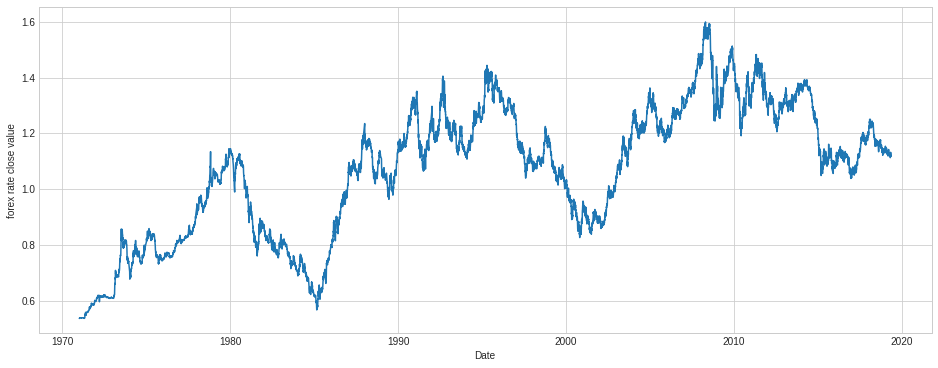

In [11]:
plt.figure(figsize=(16,6))
plt.plot(forex_data.close)
plt.xlabel('Date')
plt.ylabel('forex rate close value')
plt.show()

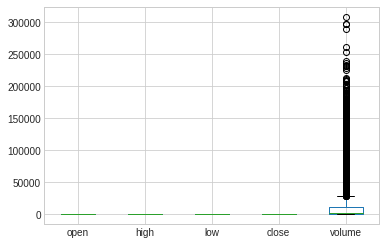

In [12]:
forex_data.boxplot()

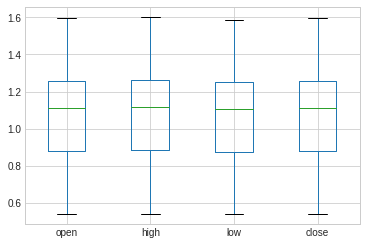

In [13]:
#boxplot for open, high, low, close
fx=forex_data.drop('volume',axis=1)
fx.boxplot()

In [14]:
#identifying and removing outliers
# calculate summary statistics
forex_volume_mean = forex_data.volume.mean()
forex_volume_mean

20323.13388361535

In [15]:
forex_volume_std

37538.1021707286

In [16]:
vol_cut_off = forex_volume_std * 3
vol_cut_off

112614.3065121858

In [17]:
lower, upper = forex_volume_mean - vol_cut_off, forex_volume_mean + vol_cut_off
lower

-92291.17262857044

In [18]:
upper

132937.44039580115

In [19]:
outliers = [x for x in forex_data.volume if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))

outliers_removed = [x for x in forex_data.volume if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Identified outliers: 317
Non-outlier observations: 11798


In [20]:
#Remove outliers above and below
forex_data.volume[forex_data.volume > upper] = upper
forex_data.volume[forex_data.volume <lower]  = lower

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
outliers = [x for x in forex_data.volume if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in forex_data.volume if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Identified outliers: 0
Non-outlier observations: 12115


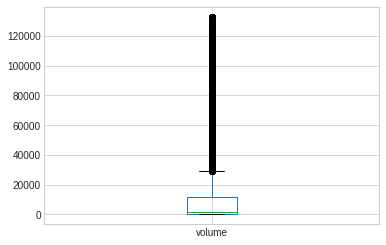

In [22]:
#boxplot for volume
forex_data[['volume']].boxplot()
plt.show()

In [23]:
forex_data.columns

Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')

In [24]:
#Generation of dataframe with new features : considering average andstandard deviation of close and volume columns
def generate_features(df):
    
    df_new=pd.DataFrame()
    
    # 6 original features
    df_new['open']=df['open']
    df_new['open_1']=df['open'].shift(1)
    df_new['low_1']=df['low'].shift(1)
    df_new['high_1']=df['high'].shift(1)
    df_new['close_1']=df['close'].shift(1)
    df_new['volume_1']=df['volume'].shift(1)
    
    #50 original features
    #average price
    df_new['avg_price_5']=df['close'].rolling(window=5).mean().shift(1)
    df_new['avg_price_30']=df['close'].rolling(window=21).mean().shift(1)
    df_new['avg_price_90']=df['close'].rolling(window=63).mean().shift(1)
    df_new['avg_price_365']=df['close'].rolling(window=252).mean().shift(1)
    
    #average price ratio
    df_new['ratio_avg_price_5_30']= df_new['avg_price_5']/ df_new['avg_price_30']
    df_new['ratio_avg_price_5_90']= df_new['avg_price_5']/ df_new['avg_price_90']
    df_new['ratio_avg_price_5_365']= df_new['avg_price_5']/ df_new['avg_price_365']
    df_new['ratio_avg_price_30_90']= df_new['avg_price_30']/ df_new['avg_price_90']
    df_new['ratio_avg_price_30_365']= df_new['avg_price_30']/ df_new['avg_price_365']
    df_new['ratio_avg_price_90_365']= df_new['avg_price_90']/ df_new['avg_price_365']
    
    #average volume
    df_new['avg_vol_5']=df['volume'].rolling(window=5).mean().shift(1)
    df_new['avg_vol_30']=df['volume'].rolling(window=21).mean().shift(1)
    df_new['avg_vol_90']=df['volume'].rolling(window=63).mean().shift(1)
    df_new['avg_vol_365']=df['volume'].rolling(window=252).mean().shift(1)
    
     #average price ratio
    df_new['ratio_avg_vol_5_30']= df_new['avg_vol_5']/ df_new['avg_vol_30']
    df_new['ratio_avg_vol_5_90']= df_new['avg_vol_5']/ df_new['avg_vol_90']
    df_new['ratio_avg_vol_5_365']= df_new['avg_vol_5']/ df_new['avg_vol_365']
    df_new['ratio_avg_vol_30_90']= df_new['avg_vol_30']/ df_new['avg_vol_90']
    df_new['ratio_avg_vol_30_365']= df_new['avg_vol_30']/ df_new['avg_vol_365']
    df_new['ratio_avg_vol_90_365']= df_new['avg_vol_90']/ df_new['avg_vol_365']
    
    #standard deviation of prices
    df_new['std_price_5']=df['close'].rolling(window=5).std().shift(1)
    df_new['std_price_30']=df['close'].rolling(window=21).std().shift(1)
    df_new['std_price_90']=df['close'].rolling(window=63).std().shift(1)
    df_new['std_price_365']=df['close'].rolling(window=252).std().shift(1)
    
    #Ratio of standard deviation of prices
    df_new['ratio_std_price_5_30']= df_new['std_price_5']/ df_new['std_price_30']
    df_new['ratio_std_price_5_90']= df_new['std_price_5']/ df_new['std_price_90']
    df_new['ratio_std_price_5_365']= df_new['std_price_5']/ df_new['std_price_365']
    df_new['ratio_std_price_30_90']= df_new['std_price_30']/ df_new['std_price_90']
    df_new['ratio_std_price_30_365']= df_new['std_price_30']/ df_new['std_price_365']
    df_new['ratio_std_price_90_365']= df_new['std_price_90']/ df_new['std_price_365']
    
    #average volume
    df_new['std_vol_5']=df['volume'].rolling(window=5).std().shift(1)
    df_new['std_vol_30']=df['volume'].rolling(window=21).std().shift(1)
    df_new['std_vol_90']=df['volume'].rolling(window=63).std().shift(1)
    df_new['std_vol_365']=df['volume'].rolling(window=252).std().shift(1)
    
     #ratio of standard deviation of volume
    df_new['ratio_std_vol_5_30']= df_new['std_vol_5']/ df_new['std_vol_30']
    df_new['ratio_std_vol_5_90']= df_new['std_vol_5']/ df_new['std_vol_90']
    df_new['ratio_std_vol_5_365']= df_new['std_vol_5']/ df_new['std_vol_365']
    df_new['ratio_std_vol_30_90']= df_new['std_vol_30']/ df_new['std_vol_90']
    df_new['ratio_std_vol_30_365']= df_new['std_vol_30']/ df_new['std_vol_365']
    df_new['ratio_std_vol_90_365']= df_new['std_vol_90']/ df_new['std_vol_365']
    
    #return
    df_new['return_1']=((df['close']-df['close'].shift(1))/df['close'].shift(1)).shift(1)
    df_new['return_5']=((df['close']-df['close'].shift(5))/df['close'].shift(5)).shift(1)
    df_new['return_30']=((df['close']-df['close'].shift(21))/df['close'].shift(21)).shift(1)
    df_new['return_90']=((df['close']-df['close'].shift(63))/df['close'].shift(63)).shift(1)
    df_new['return_365']=((df['close']-df['close'].shift(252))/df['close'].shift(252)).shift(1)
    
    # average of return
    df_new['moving_avg_5']=df_new['return_1'].rolling(window=5).mean()
    df_new['moving_avg_30']=df_new['return_1'].rolling(window=21).mean()
    df_new['moving_avg_90']=df_new['return_1'].rolling(window=63).mean()
    df_new['moving_avg_365']=df_new['return_1'].rolling(window=252).mean()
    
    df_new['close']=df['close']
    df_new=df_new.dropna(axis=0)
    return df_new

data=generate_features(forex_data)

In [25]:
data

,open,open_1,low_1,high_1,close_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,ratio_avg_price_5_30,ratio_avg_price_5_90,ratio_avg_price_5_365,ratio_avg_price_30_90,ratio_avg_price_30_365,ratio_avg_price_90_365,avg_vol_5,avg_vol_30,avg_vol_90,avg_vol_365,ratio_avg_vol_5_30,ratio_avg_vol_5_90,ratio_avg_vol_5_365,ratio_avg_vol_30_90,ratio_avg_vol_30_365,ratio_avg_vol_90_365,std_price_5,std_price_30,std_price_90,std_price_365,ratio_std_price_5_30,ratio_std_price_5_90,ratio_std_price_5_365,ratio_std_price_30_90,ratio_std_price_30_365,ratio_std_price_90_365,std_vol_5,std_vol_30,std_vol_90,std_vol_365,ratio_std_vol_5_30,ratio_std_vol_5_90,ratio_std_vol_5_365,ratio_std_vol_30_90,ratio_std_vol_30_365,ratio_std_vol_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_90,moving_avg_365,close
1972-05-24,0.61560,0.61540,0.61510,0.61540,0.61530,51.0,0.615020,0.615143,0.615479,0.588782,0.999800,0.999254,1.044563,0.999453,1.044772,1.045343,11.0,3.380952,1.793651,1.198413,3.253521,6.132743,9.178808,1.884956,2.821192,1.496689,0.000228,0.000541,0.002886,0.023657,0.421586,0.079025,0.009639,0.187446,0.022864,0.121978,22.360680,10.910895,6.299408,3.149704,2.049390,3.549648,7.099296,1.732051,3.464102,2.000000,0.000325,0.002281,-0.000812,0.000488,0.143043,0.000456,-0.000038,0.000027,0.000539,0.61560
1972-05-25,0.61470,0.61560,0.61560,0.61560,0.61560,1.0,0.615160,0.615152,0.615530,0.589088,1.000012,0.999399,1.044257,0.999386,1.044244,1.044886,11.0,3.380952,1.793651,1.198413,3.253521,6.132743,9.178808,1.884956,2.821192,1.496689,0.000329,0.000547,0.002859,0.023501,0.600381,0.114964,0.013984,0.191485,0.023291,0.121635,22.360680,10.910895,6.299408,3.149704,2.049390,3.549648,7.099296,1.732051,3.464102,2.000000,0.000488,0.001138,0.000325,0.005225,0.143388,0.000228,0.000016,0.000102,0.000540,0.61470
1972-05-26,0.61530,0.61470,0.61470,0.61470,0.61470,1.0,0.615080,0.615133,0.615551,0.589391,0.999913,0.999235,1.043586,0.999322,1.043676,1.044385,11.0,3.380952,1.793651,1.198413,3.253521,6.132743,9.178808,1.884956,2.821192,1.496689,0.000390,0.000556,0.002848,0.023337,0.700985,0.136911,0.016706,0.195312,0.023832,0.122020,22.360680,10.910895,6.299408,3.149704,2.049390,3.549648,7.099296,1.732051,3.464102,2.000000,-0.001462,-0.000650,-0.000650,0.002119,0.141504,-0.000130,-0.000031,0.000053,0.000534,0.61530
1972-05-30,0.61590,0.61530,0.61530,0.61530,0.61530,1.0,0.615200,0.615129,0.615557,0.589695,1.000116,0.999420,1.043251,0.999304,1.043130,1.043857,11.0,3.380952,1.793651,1.198413,3.253521,6.132743,9.178808,1.884956,2.821192,1.496689,0.000332,0.000554,0.002847,0.023173,0.598448,0.116512,0.014313,0.194690,0.023916,0.122842,22.360680,10.910895,6.299408,3.149704,2.049390,3.549648,7.099296,1.732051,3.464102,2.000000,0.000976,0.000976,-0.000162,0.000651,0.142194,0.000196,-0.000007,0.000029,0.000536,0.61590
1972-05-31,0.61570,0.61590,0.61590,0.61590,0.61590,1.0,0.615360,0.615171,0.615573,0.589970,1.000307,0.999654,1.043036,0.999348,1.042716,1.043397,11.0,3.380952,1.793651,1.198413,3.253521,6.132743,9.178808,1.884956,2.821192,1.496689,0.000445,0.000578,0.002846,0.023070,0.769780,0.156368,0.019288,0.203134,0.025057,0.123352,22.360680,10.910895,6.299408,3.149704,2.049390,3.549648,7.099296,1.732051,3.464102,2.000000,0.000975,0.001301,0.001463,0.001626,0.126990,0.000260,0.000070,0.000045,0.000482,0.61570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-01,1.12148,1.11841,1.11753,1.12286,1.12140,55570.0,1.116498,1.123167,1.128969,1.147996,0.994063,0.988954,0.972563,0.994861,0.978372,0.983426,53532.6,48192.142857,56535.539683,76641.331441,1.110816,0.946884,0.698482,0.852422,0.628801,0.737664,0.003403,0.004909,0.006955,0.017760,0.693242,0.489329,0.191614,0.705856,0.276403,0.391585,10051.030683,11821.664901,12120.611022,22410.846934,0.850221,0

In [26]:
data.describe()

,open,open_1,low_1,high_1,close_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,ratio_avg_price_5_30,ratio_avg_price_5_90,ratio_avg_price_5_365,ratio_avg_price_30_90,ratio_avg_price_30_365,ratio_avg_price_90_365,avg_vol_5,avg_vol_30,avg_vol_90,avg_vol_365,ratio_avg_vol_5_30,ratio_avg_vol_5_90,ratio_avg_vol_5_365,ratio_avg_vol_30_90,ratio_avg_vol_30_365,ratio_avg_vol_90_365,std_price_5,std_price_30,std_price_90,std_price_365,ratio_std_price_5_30,ratio_std_price_5_90,ratio_std_price_5_365,ratio_std_price_30_90,ratio_std_price_30_365,ratio_std_price_90_365,std_vol_5,std_vol_30,std_vol_90,std_vol_365,ratio_std_vol_5_30,ratio_std_vol_5_90,ratio_std_vol_5_365,ratio_std_vol_30_90,ratio_std_vol_30_365,ratio_std_vol_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_90,moving_avg_365,close
count,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,1.178100e+04,1.178100e+04,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000
mean,1.086904,1.086862,1.082905,1.090896,1.086904,20154.319040,1.086818,1.086474,1.085562,1.081191,1.000441,1.001699,1.007817,1.001140,1.007194,1.005646,20148.169596,20115.494338,20015.020558,19440.397185,1.011093,1.040644,1.174306,1.018381,1.137914,1.090073,0.005885,0.011987,0.021626,0.046234,0.542663,0.304121,0.137981,0.601744,0.281261,0.498372,2465.994065,3300.113976,4045.295596,5116.398342,0.843042,0.750063,0.655062,8.931450e-01,7.880482e-01,0.883381,0.000072,0.000362,0.001570,0.004863,0.021690,0.000072,0.000072,0.000072,0.000078,1.086947
std,0.222026,0.222068,0.220081,0.224058,0.222061,35060.393836,0.222054,0.222072,0.222038,0.221877,0.013681,0.030010,0.067033,0.021829,0.062700,0.051228,34708.635331,34424.081351,34129.858555,33326.364500,0.337854,0.545111,1.212660,0.259783,0.752839,0.419677,0.004058,0.006951,0.011470,0.020030,0.300998,0.202918,0.111631,0.268763,0.173539,0.237806,4944.363921,5915.143103,6824.470230,8335.854496,0.430794,0.505685,0.581460,3.133744e-01,4.523471e-01,0.330634,0.006479,0.014625,0.031592,0.057053,0.123511,0.002923,0.001500,0.000903,0.000474,0.222019
min,0.567200,0.567200,0.563300,0.568600,0.567200,1.000000,0.574540,0.580143,0.601424,0.588782,0.949440,0.894925,0.811752,0.930375,0.831614,0.856529,1.000000,3.380952,1.793651,1.198413,0.032258,0.021627,0.044429,0.157040,0.105984,0.127704,0.000130,0.000526,0.001085,0.003486,0.030081,0.007598,0.005776,0.063063,0.022864,0.054329,0.000000,0.003311,6.299408,3.149704,0.000000,0.000000,0.000000,2.071391e-07,1.251220e-07,0.044556,-0.056418,-0.095796,-0.147266,-0.200039,-0.325111,-0.019757,-0.007495,-0.003489,-0.001531,0.567200
25%,0.900500,0.900500,0.896400,0.904500,0.900500,291.000000,0.899380,0.901238,0.898514,0.895626,0.992055,0.982520,0.960094,0.986893,0.963114,0.969232,365.000000,381.476190,401.634921,418.500000,0.872845,0.817516,0.764937,0.893501,0.822207,0.871073,0.003155,0.007358,0.013526,0.031401,0.317024,0.166563,0.074757,0.398756,0.169611,0.326840,236.962444,350.149628,389.474879,453.476352,0.514806,0.399976,0.308333,6.792980e-01,4.903441e-01,0.652543,-0.003369,-0.008254,-0.017748,-0.032792,-0.072561,-0.001642,-0.000833,-0.000510,-0.000279,0.900500
50%,1.118400,1.118350,1.114000,1.122400,1.118520,2071.000000,1.119028,1.117914,1.113101,1.110632,1.000404,1.001541,1.006821,1.001209,1.006682,1.006298,1977.000000,1911.476190,1896.079365,1980.682540,0.993845,0.984134,0.988058,0.993600,0.999261,1.01434

In [27]:
###Splitting the data

In [28]:
#import datetime module
import datetime

#Segregate training data
train_start=datetime.datetime(1999,1,1,0,0)
train_end=datetime.datetime(2017,12,31,0,0)
train_data=data.loc[train_start:train_end]
train_data.describe()

,open,open_1,low_1,high_1,close_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,ratio_avg_price_5_30,ratio_avg_price_5_90,ratio_avg_price_5_365,ratio_avg_price_30_90,ratio_avg_price_30_365,ratio_avg_price_90_365,avg_vol_5,avg_vol_30,avg_vol_90,avg_vol_365,ratio_avg_vol_5_30,ratio_avg_vol_5_90,ratio_avg_vol_5_365,ratio_avg_vol_30_90,ratio_avg_vol_30_365,ratio_avg_vol_90_365,std_price_5,std_price_30,std_price_90,std_price_365,ratio_std_price_5_30,ratio_std_price_5_90,ratio_std_price_5_365,ratio_std_price_30_90,ratio_std_price_30_365,ratio_std_price_90_365,std_vol_5,std_vol_30,std_vol_90,std_vol_365,ratio_std_vol_5_30,ratio_std_vol_5_90,ratio_std_vol_5_365,ratio_std_vol_30_90,ratio_std_vol_30_365,ratio_std_vol_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_90,moving_avg_365,close
count,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4.941000e+03,4.941000e+03,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000
mean,1.207845,1.207844,1.202155,1.213555,1.207882,40948.114379,1.207882,1.207862,1.207876,1.207394,1.000044,1.000171,1.001250,1.000037,1.001081,1.000759,40918.319924,40780.041191,40463.938837,38663.015890,1.011099,1.041951,1.205963,1.022836,1.170854,1.117929,0.006470,0.012814,0.022393,0.047303,0.555956,0.321877,0.148122,0.623705,0.293985,0.505162,4542.926708,6248.042201,7675.028014,9778.707858,0.787251,0.660916,0.520427,8.499911e-01,6.854620e-01,0.816631,0.000020,0.000097,0.000457,0.001223,0.005686,0.000021,0.000022,0.000019,0.000022,1.207885
std,0.172721,0.172721,0.172127,0.173244,0.172677,40535.398337,0.172545,0.172101,0.170867,0.164983,0.012569,0.026763,0.057658,0.019465,0.054063,0.044576,39948.109411,39435.308073,39026.738219,37726.547635,0.163677,0.366153,0.999129,0.174191,0.670447,0.373853,0.003894,0.006756,0.011477,0.020875,0.295577,0.186868,0.084335,0.250443,0.139508,0.214244,6202.465616,7220.078631,7943.757005,9468.948639,0.420002,0.468872,0.469948,3.202786e-01,4.144352e-01,0.323131,0.006320,0.013728,0.028651,0.050264,0.101303,0.002745,0.001363,0.000801,0.000400,0.172676
min,0.827200,0.827200,0.822700,0.832600,0.826700,1.000000,0.833560,0.849195,0.858429,0.883636,0.949875,0.894925,0.826901,0.931309,0.852838,0.883052,168.800000,179.904762,206.666667,190.730159,0.308371,0.345970,0.418912,0.546644,0.619589,0.691981,0.000365,0.003002,0.006381,0.015971,0.031109,0.021686,0.007469,0.117013,0.064991,0.133604,0.000000,0.003311,64.580532,186.622525,0.000000,0.000000,0.000000,2.071391e-07,1.251220e-07,0.197396,-0.026604,-0.065191,-0.147266,-0.200039,-0.241870,-0.013307,-0.007495,-0.003489,-0.001086,0.826700
25%,1.086760,1.086760,1.080950,1.091700,1.086720,9051.000000,1.086860,1.086086,1.093687,1.102289,0.991980,0.982476,0.956647,0.986492,0.959101,0.966002,9050.400000,9040.095238,9071.095238,8945.166667,0.950242,0.929448,0.893880,0.952380,0.909005,0.924305,0.003785,0.008415,0.014517,0.031370,0.334962,0.184184,0.088755,0.432417,0.192123,0.340213,503.369347,702.308594,884.735550,1291.370850,0.469168,0.346896,0.252775,6.379958e-01,4.025237e-01,0.575167,-0.003710,-0.008580,-0.017528,-0.033266,-0.071921,-0.001699,-0.000823,-0.000515,-0.000276,1.086720
50%,1.232600,1.232600,1.226040,1.238200,1.232320,13905.000000,1.232142,1.230429,1.237444,1.240565,1.000064,1.001180,1.007453,1.000682,1.007681,1.006557,13682.000000,13271.761905,13230.380952,10932.087302,1.001368,1.004517,1.032327,1.001405,1.030141,1.027439,0.005628,0.011372,0.019380,0.0

In [29]:
data.describe()

,open,open_1,low_1,high_1,close_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,ratio_avg_price_5_30,ratio_avg_price_5_90,ratio_avg_price_5_365,ratio_avg_price_30_90,ratio_avg_price_30_365,ratio_avg_price_90_365,avg_vol_5,avg_vol_30,avg_vol_90,avg_vol_365,ratio_avg_vol_5_30,ratio_avg_vol_5_90,ratio_avg_vol_5_365,ratio_avg_vol_30_90,ratio_avg_vol_30_365,ratio_avg_vol_90_365,std_price_5,std_price_30,std_price_90,std_price_365,ratio_std_price_5_30,ratio_std_price_5_90,ratio_std_price_5_365,ratio_std_price_30_90,ratio_std_price_30_365,ratio_std_price_90_365,std_vol_5,std_vol_30,std_vol_90,std_vol_365,ratio_std_vol_5_30,ratio_std_vol_5_90,ratio_std_vol_5_365,ratio_std_vol_30_90,ratio_std_vol_30_365,ratio_std_vol_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_90,moving_avg_365,close
count,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,1.178100e+04,1.178100e+04,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000
mean,1.086904,1.086862,1.082905,1.090896,1.086904,20154.319040,1.086818,1.086474,1.085562,1.081191,1.000441,1.001699,1.007817,1.001140,1.007194,1.005646,20148.169596,20115.494338,20015.020558,19440.397185,1.011093,1.040644,1.174306,1.018381,1.137914,1.090073,0.005885,0.011987,0.021626,0.046234,0.542663,0.304121,0.137981,0.601744,0.281261,0.498372,2465.994065,3300.113976,4045.295596,5116.398342,0.843042,0.750063,0.655062,8.931450e-01,7.880482e-01,0.883381,0.000072,0.000362,0.001570,0.004863,0.021690,0.000072,0.000072,0.000072,0.000078,1.086947
std,0.222026,0.222068,0.220081,0.224058,0.222061,35060.393836,0.222054,0.222072,0.222038,0.221877,0.013681,0.030010,0.067033,0.021829,0.062700,0.051228,34708.635331,34424.081351,34129.858555,33326.364500,0.337854,0.545111,1.212660,0.259783,0.752839,0.419677,0.004058,0.006951,0.011470,0.020030,0.300998,0.202918,0.111631,0.268763,0.173539,0.237806,4944.363921,5915.143103,6824.470230,8335.854496,0.430794,0.505685,0.581460,3.133744e-01,4.523471e-01,0.330634,0.006479,0.014625,0.031592,0.057053,0.123511,0.002923,0.001500,0.000903,0.000474,0.222019
min,0.567200,0.567200,0.563300,0.568600,0.567200,1.000000,0.574540,0.580143,0.601424,0.588782,0.949440,0.894925,0.811752,0.930375,0.831614,0.856529,1.000000,3.380952,1.793651,1.198413,0.032258,0.021627,0.044429,0.157040,0.105984,0.127704,0.000130,0.000526,0.001085,0.003486,0.030081,0.007598,0.005776,0.063063,0.022864,0.054329,0.000000,0.003311,6.299408,3.149704,0.000000,0.000000,0.000000,2.071391e-07,1.251220e-07,0.044556,-0.056418,-0.095796,-0.147266,-0.200039,-0.325111,-0.019757,-0.007495,-0.003489,-0.001531,0.567200
25%,0.900500,0.900500,0.896400,0.904500,0.900500,291.000000,0.899380,0.901238,0.898514,0.895626,0.992055,0.982520,0.960094,0.986893,0.963114,0.969232,365.000000,381.476190,401.634921,418.500000,0.872845,0.817516,0.764937,0.893501,0.822207,0.871073,0.003155,0.007358,0.013526,0.031401,0.317024,0.166563,0.074757,0.398756,0.169611,0.326840,236.962444,350.149628,389.474879,453.476352,0.514806,0.399976,0.308333,6.792980e-01,4.903441e-01,0.652543,-0.003369,-0.008254,-0.017748,-0.032792,-0.072561,-0.001642,-0.000833,-0.000510,-0.000279,0.900500
50%,1.118400,1.118350,1.114000,1.122400,1.118520,2071.000000,1.119028,1.117914,1.113101,1.110632,1.000404,1.001541,1.006821,1.001209,1.006682,1.006298,1977.000000,1911.476190,1896.079365,1980.682540,0.993845,0.984134,0.988058,0.993600,0.999261,1.01434

In [30]:
#splitting test data
test_start=datetime.datetime(2018,1,1,0,0)
test_end=datetime.datetime(2019,6,7,0,0)
test_data=data.loc[test_start:test_end]
test_data.describe()

,open,open_1,low_1,high_1,close_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,ratio_avg_price_5_30,ratio_avg_price_5_90,ratio_avg_price_5_365,ratio_avg_price_30_90,ratio_avg_price_30_365,ratio_avg_price_90_365,avg_vol_5,avg_vol_30,avg_vol_90,avg_vol_365,ratio_avg_vol_5_30,ratio_avg_vol_5_90,ratio_avg_vol_5_365,ratio_avg_vol_30_90,ratio_avg_vol_30_365,ratio_avg_vol_90_365,std_price_5,std_price_30,std_price_90,std_price_365,ratio_std_price_5_30,ratio_std_price_5_90,ratio_std_price_5_365,ratio_std_price_30_90,ratio_std_price_30_365,ratio_std_price_90_365,std_vol_5,std_vol_30,std_vol_90,std_vol_365,ratio_std_vol_5_30,ratio_std_vol_5_90,ratio_std_vol_5_365,ratio_std_vol_30_90,ratio_std_vol_30_365,ratio_std_vol_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_90,moving_avg_365,close
count,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000
mean,1.168335,1.168551,1.164774,1.172679,1.168404,85860.709055,1.168790,1.170189,1.173200,1.175544,0.998793,0.996236,0.994591,0.997405,0.995734,0.998183,86076.016791,86934.733888,88030.342202,94176.970161,0.988373,0.977635,0.904970,0.985270,0.914560,0.928420,0.004493,0.007760,0.013166,0.034938,0.641844,0.406201,0.133445,0.675926,0.229061,0.385768,11868.015924,14836.028080,19042.542858,24416.037848,0.822346,0.678377,0.483281,0.823017,0.608195,0.785246,-0.000176,-0.000785,-0.002987,-0.007239,0.014224,-0.000156,-0.000140,-0.000114,0.000052,1.168174
std,0.038680,0.038614,0.038099,0.039068,0.038646,28427.264667,0.038265,0.036942,0.033194,0.017669,0.007005,0.015896,0.039145,0.011528,0.036849,0.030485,25325.257054,22834.340185,18174.794771,6771.873736,0.120040,0.203985,0.227735,0.140025,0.196934,0.145145,0.002091,0.003494,0.006873,0.009082,0.296836,0.226364,0.064043,0.286032,0.096374,0.205507,6936.294137,5716.490049,5363.318265,1756.643190,0.437726,0.415915,0.282394,0.295385,0.239640,0.234142,0.004373,0.009027,0.016337,0.030892,0.086742,0.001806,0.000780,0.000491,0.000332,0.038700
min,1.113220,1.113220,1.111050,1.116200,1.113130,698.000000,1.116498,1.122836,1.127743,1.131791,0.980278,0.958818,0.951931,0.972393,0.958439,0.965983,38445.800000,46228.190476,55696.301587,75754.640965,0.650007,0.560327,0.496184,0.695282,0.610236,0.735220,0.001020,0.002998,0.005511,0.017220,0.102330,0.070232,0.031783,0.247986,0.082951,0.152565,0.000000,683.554534,11209.957491,21197.313418,0.000000,0.000000,0.000000,0.023540,0.030068,0.430578,-0.019107,-0.022843,-0.046899,-0.067556,-0.094090,-0.004603,-0.002279,-0.001100,-0.000383,1.113130
25%,1.136580,1.136750,1.133530,1.140910,1.136570,64344.000000,1.136546,1.137379,1.139820,1.161746,0.994924,0.988730,0.969421,0.992249,0.972179,0.974901,67880.600000,71394.904762,75140.476190,94076.698964,0.917240,0.837960,0.747187,0.881679,0.767924,0.807359,0.002958,0.005275,0.007392,0.028970,0.412920,0.229843,0.088893,0.397357,0.157059,0.247724,7572.713827,10828.324151,14084.804763,22811.431190,0.528578,0.432423,0.306273,0.666748,0.441971,0.569664,-0.002896,-0.007221,-0.011647,-0.025809,-0.054522,-0.001444,-0.000548,-0.000410,-0.000213,1.136550
50%,1.158720,1.158740,1.154300,1.162750,1.159300,79792.000000,1.161040,1.162870,1.162962,1.181830,0.999062,0.995503,0.976496,0.996417,0.977435,0.982091,79739.600000,79377.952381,83083.923841,96578.271667,1.001123,0.960873,0.840478,0.975436,0.834447,0.859325,0.004178,0.006529,0.010582,0.033038,0.610560,0.347427,0.122462,0.686323,0.204063,0

In [31]:
train_X=train_data.drop('close', axis='columns')
train_Y=train_data.close

validation_X=test_data.drop('close', axis='columns')
validation_Y=test_data.close

train_X.shape, train_Y.shape, validation_X.shape, validation_Y.shape

((4941, 55), (4941,), (349, 55), (349,))

In [32]:
train_Y

1999-01-04    1.18150
1999-01-05    1.17580
1999-01-06    1.16230
1999-01-07    1.17120
1999-01-08    1.15850
               ...   
2017-12-22    1.18630
2017-12-26    1.18579
2017-12-27    1.18865
2017-12-28    1.19422
2017-12-29    1.19941
Name: close, Length: 4941, dtype: float64

In [33]:
###SCALING the DATA

In [34]:
#initiating standard scaler
scaler = StandardScaler()

#fit the scaler in training features
scaler.fit(train_X)

#Rescale both sets using the trained scaler
X_scaled_train = scaler.transform(train_X)
X_scaled_test = scaler.transform(validation_X)


In [35]:
X_scaled_train

array([[-0.16064972, -0.09753195, -0.11826582, ...,  0.14759251,
         0.39867504,  0.77817983],
       [-0.15254334, -0.1606459 , -0.14673606, ...,  0.07078634,
         0.37379578,  0.74522782],
       [-0.18381081, -0.15253952, -0.15777554, ...,  0.03262485,
         0.22516209,  0.54060247],
       ...,
       [-0.12770307, -0.12046142, -0.1016485 , ..., -0.22078966,
         0.17640083,  1.07658313],
       [-0.11114289, -0.12769926, -0.09670978, ..., -0.04599097,
         0.15433513,  1.17717258],
       [-0.07889107, -0.11113908, -0.07852369, ...,  0.29573693,
         0.20130627,  1.17765599]])

In [36]:
###LINEAR REGRESSION

In [37]:
lin=LinearRegression()

lin.fit(X_scaled_train,train_Y)
lin_prediction=lin.predict(X_scaled_test)

In [38]:
print('RMSE:{0:.3f}'.format(mean_squared_error(validation_Y,lin_prediction)**0.5))
print('MAE:{0:.3f}'.format(mean_absolute_error(validation_Y,lin_prediction)))
print('R^2:{0:.3f}'.format(r2_score(validation_Y,lin_prediction)))

RMSE:0.005
MAE:0.004
R^2:0.983


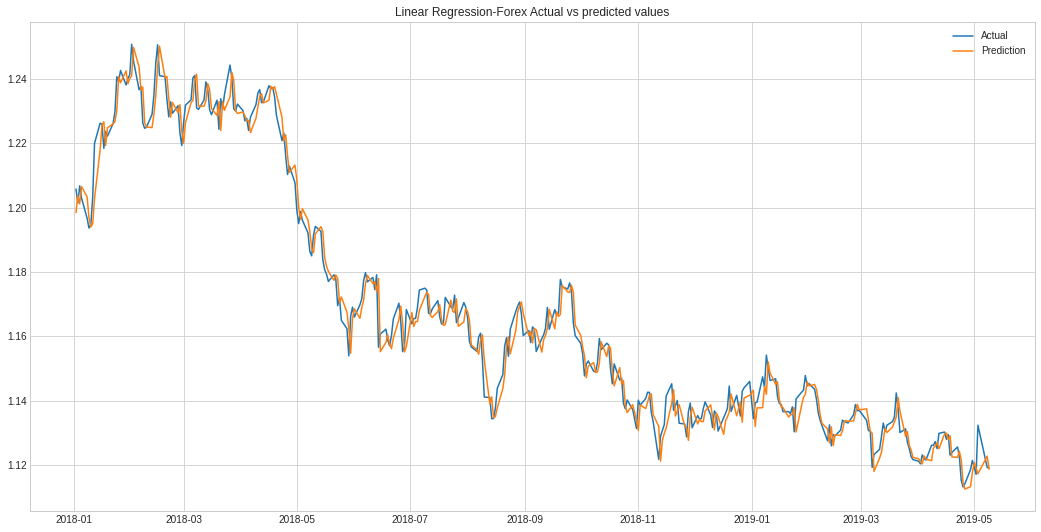

In [39]:
dates=test_data.index.values

fig = plt.figure(figsize=(18,9))
plt.plot(dates,validation_Y, label='Actual')
plt.plot(dates,lin_prediction, label='Prediction')
plt.legend()
plt.title('Linear Regression-Forex Actual vs predicted values')
plt.show()

In [40]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# train_X = [[1,2],[2,4],[6,7]]
#train_Y = [1.2, 4.5, 6.7]
# validation_X = [[1,3],[2,5]] 


#pass the order of your polynomial here
poly = PolynomialFeatures()

#Convert to use for Linear regression later
X_transform = poly.fit_transform(X_scaled_train)
X_test_transform = poly.fit_transform(X_scaled_test)

X_transform

array([[ 1.        , -0.16064972, -0.09753195, ...,  0.15894179,
         0.31024087,  0.60556385],
       [ 1.        , -0.15254334, -0.1606459 , ...,  0.13972328,
         0.27856301,  0.55536451],
       [ 1.        , -0.18381081, -0.15253952, ...,  0.05069797,
         0.12172318,  0.29225103],
       ...,
       [ 1.        , -0.12770307, -0.12046142, ...,  0.03111725,
         0.18991016,  1.15903125],
       [ 1.        , -0.11114289, -0.12769926, ...,  0.02381933,
         0.18167908,  1.38573529],
       [ 1.        , -0.07889107, -0.11113908, ...,  0.04052421,
         0.23706953,  1.38687362]])

In [41]:
#create a linear regressor
lin_regressor = LinearRegression()

#fit this to Linear Regressor
lin_regressor.fit(X_transform,train_Y)

#get the predictions
Y_poly_predictions = lin_regressor.predict(X_test_transform)


In [42]:
print('RMSE:{0:.3f}'.format(mean_squared_error(validation_Y,Y_poly_predictions)**0.5))
print('MAE:{0:.3f}'.format(mean_absolute_error(validation_Y,Y_poly_predictions)))
print('R^2:{0:.3f}'.format(r2_score(validation_Y,Y_poly_predictions)))

RMSE:0.036
MAE:0.023
R^2:0.124


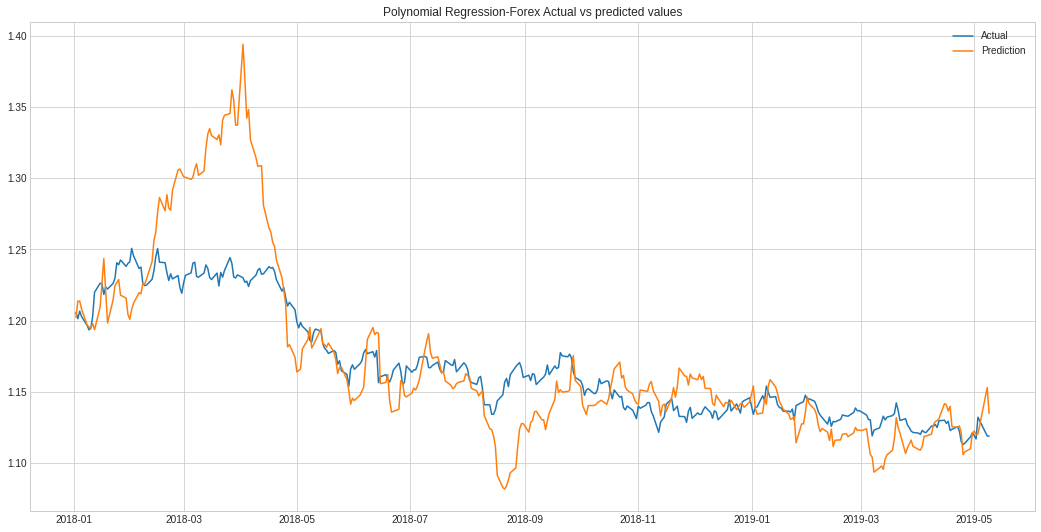

In [43]:
dates=test_data.index.values

fig = plt.figure(figsize=(18,9))
plt.plot(dates,validation_Y, label='Actual')
plt.plot(dates,Y_poly_predictions, label='Prediction')
plt.legend()
plt.title('Polynomial Regression-Forex Actual vs predicted values')
plt.show()

In [44]:
#Extreme Gradient Boosting Regressor

In [45]:
xgb = XGBRegressor()

data_dmatrix = DMatrix(data=train_X,
                           label=train_Y)

xgb_param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1],
                  'n_estimators': [50, 100, 200, 300],
                  'subsample': [0.3, 0.5, 0.7, 1]}

grid_search = GridSearchCV(estimator=xgb,    
                        param_grid=xgb_param_grid,
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                       n_jobs=-1)

grid_search.fit(train_X, train_Y) 

print("Best parameters found: ",grid_search.best_params_)

xgb_best = grid_search.best_estimator_

xgb_best.fit(train_X,train_Y)
predictions_xgb = xgb_best.predict(validation_X)

print('RMSE: {0:.3f}'.format(mean_squared_error(validation_Y, predictions_xgb)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(validation_Y, predictions_xgb)))
print('R^2: {0:.3f}'.format(r2_score(validation_Y, predictions_xgb)))

Fitting 4 folds for each of 64 candidates, totalling 256 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:  6.4min finished


[20:32:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters found:  {'learning_rate': 1, 'n_estimators': 50, 'subsample': 1}
[20:32:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 0.008
MAE: 0.007
R^2: 0.954


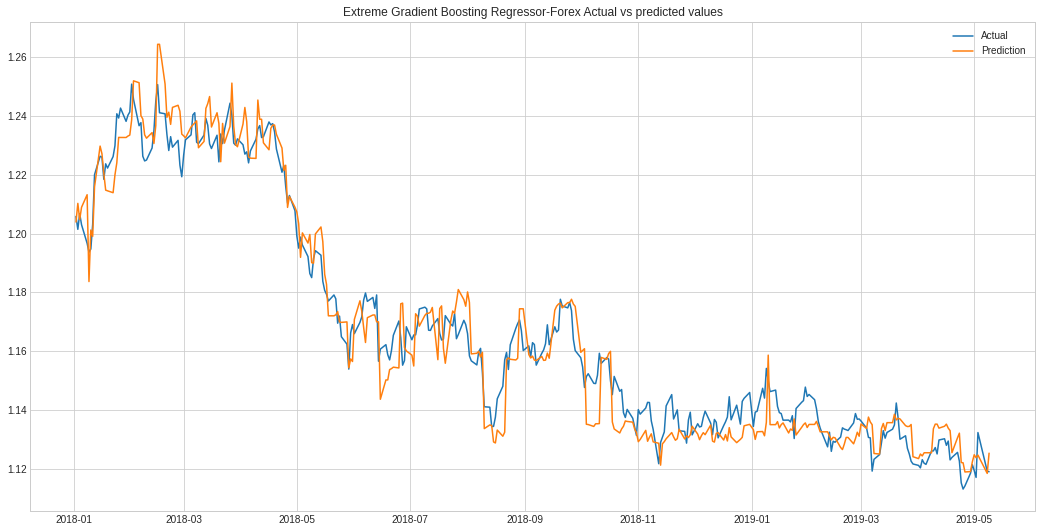

In [46]:
dates=test_data.index.values

fig = plt.figure(figsize=(18,9))
plt.plot(dates,validation_Y, label='Actual')
plt.plot(dates,predictions_xgb, label='Prediction')
plt.legend()
plt.title('Extreme Gradient Boosting Regressor-Forex Actual vs predicted values')
plt.show()

The model with the least mean_absolute_error:
 LIN    0.004009
dtype: float64


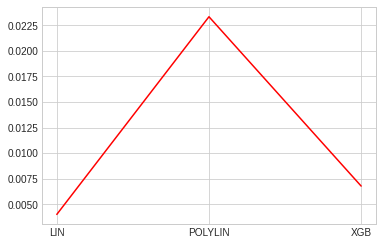

In [47]:
mae_scoring = pd.Series({'LIN':mean_absolute_error(validation_Y, lin_prediction),
                'POLYLIN':mean_absolute_error(validation_Y, Y_poly_predictions),       
                'XGB':mean_absolute_error(validation_Y, predictions_xgb)})

#filtering the regressor with the least mean_absolute_error value
filter = mae_scoring.min()
mae_min = mae_scoring[mae_scoring == mae_scoring.min()]
print('The model with the least mean_absolute_error:\n',mae_min)

plt.plot(mae_scoring, 'r')

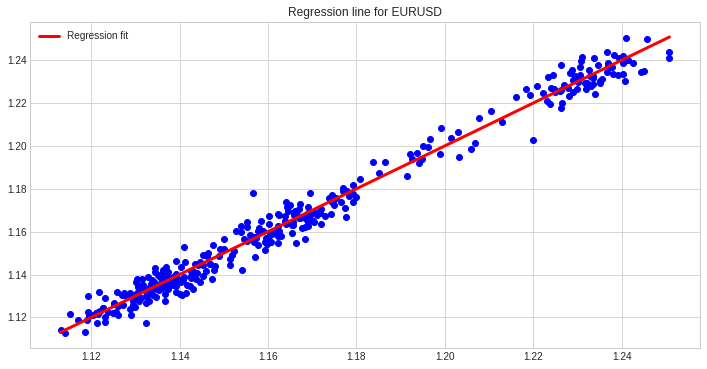

In [48]:
#plotting the regression line
plt.style.use('seaborn-whitegrid')
plt.scatter(validation_Y,lin.predict(X_scaled_test),color='blue')
plt.plot([validation_Y.min(),validation_Y.max()],[validation_Y.min(),validation_Y.max()],color='red',linewidth=3,label='Regression fit')
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.title("Regression line for EURUSD")
plt.legend()
plt.show()

In [49]:
#LSTM

In [50]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,GRU
from keras.layers import Dropout

In [51]:
X_scaled_train.shape

(4941, 55)

In [52]:
# X_scaled_train = numpy.reshape(X_scaled_train, (X_scaled_train.shape[0], 1, X_scaled_train.shape[1]))
# X_scaled_test = numpy.reshape(X_scaled_test, (X_scaled_test.shape[0], 1, X_scaled_test.shape[1]))

X_train, y_train = np.array(X_scaled_train), np.array(train_Y)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [53]:
X_train.shape,y_train.shape

((4941, 55, 1), (4941,))

#create and fit the LSTM network

In [54]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
155/155 [==============================] - 31s 143ms/step - loss: 0.0964
Epoch 2/20
155/155 [==============================] - 22s 143ms/step - loss: 0.0160
Epoch 3/20
155/155 [==============================] - 22s 144ms/step - loss: 0.0123
Epoch 4/20
155/155 [==============================] - 22s 141ms/step - loss: 0.0110
Epoch 5/20
155/155 [==============================] - 22s 141ms/step - loss: 0.0096
Epoch 6/20
155/155 [==============================] - 22s 142ms/step - loss: 0.0093
Epoch 7/20
155/155 [==============================] - 22s 142ms/step - loss: 0.0086
Epoch 8/20
155/155 [==============================] - 22s 142ms/step - loss: 0.0083
Epoch 9/20
155/155 [==============================] - 22s 141ms/step - loss: 0.0080
Epoch 10/20
155/155 [==============================] - 22s 141ms/step - loss: 0.0074
Epoch 11/20
155/155 [==============================] - 22s 142ms/step - loss: 0.0076
Epoch 12/20
155/155 [==============================] - 22s 141ms/step - lo

In [55]:
X_scaled_test = np.reshape(X_scaled_test, (X_scaled_test.shape[0], X_scaled_test.shape[1], 1))

predictions_lstm = regressor.predict(X_scaled_test)
predictions_lstm

array([[1.1786933],
       [1.1850022],
       [1.1695162],
       [1.1795689],
       [1.1827965],
       [1.1622808],
       [1.1574031],
       [1.168712 ],
       [1.1718287],
       [1.1598121],
       [1.1424412],
       [1.1467327],
       [1.1687838],
       [1.1947786],
       [1.1964453],
       [1.1942674],
       [1.1931225],
       [1.1937069],
       [1.1958163],
       [1.2034785],
       [1.2106853],
       [1.2254615],
       [1.2238626],
       [1.2175348],
       [1.2148464],
       [1.2073544],
       [1.202525 ],
       [1.1809483],
       [1.1725619],
       [1.1741418],
       [1.1775162],
       [1.183631 ],
       [1.1792357],
       [1.1845855],
       [1.1922941],
       [1.1962115],
       [1.1999061],
       [1.1833801],
       [1.189148 ],
       [1.1811501],
       [1.1935346],
       [1.1850563],
       [1.17269  ],
       [1.1761947],
       [1.176636 ],
       [1.176664 ],
       [1.1787192],
       [1.190261 ],
       [1.1916419],
       [1.1876733],


In [56]:
print('RMSE: {0:.3f}'.format(mean_squared_error(validation_Y, predictions_lstm)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(validation_Y, predictions_lstm)))
print('R^2: {0:.3f}'.format(r2_score(validation_Y, predictions_lstm)))

RMSE: 0.026
MAE: 0.021
R^2: 0.531


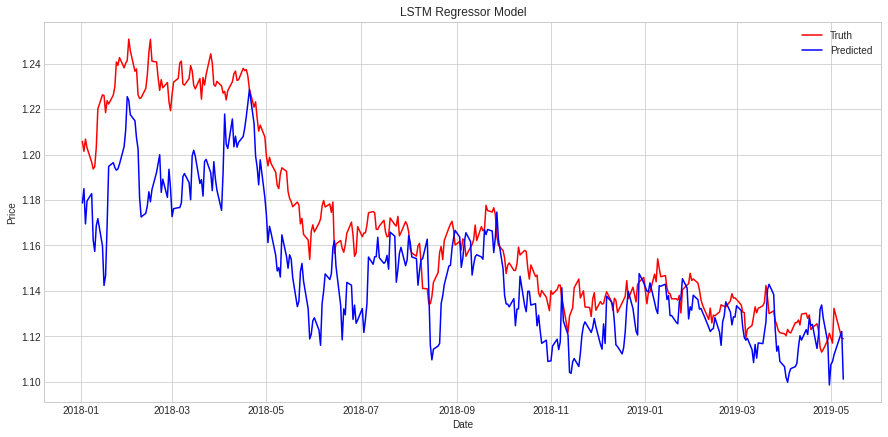

In [57]:
plt.figure(figsize=(15,7))
plt.plot(validation_Y, 'r', label='Truth')
plt.plot(validation_Y.index, predictions_lstm, 'b', label='Predicted')
plt.title("LSTM Regressor Model")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

GRU Unit

In [58]:
from keras.layers import GRU




regressor = Sequential()

regressor.add(GRU(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(GRU(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(GRU(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(GRU(units = 20))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
155/155 [==============================] - 24s 113ms/step - loss: 0.1294
Epoch 2/20
155/155 [==============================] - 18s 113ms/step - loss: 0.0538
Epoch 3/20
155/155 [==============================] - 18s 113ms/step - loss: 0.0483
Epoch 4/20
155/155 [==============================] - 18s 113ms/step - loss: 0.0303
Epoch 5/20
155/155 [==============================] - 17s 113ms/step - loss: 0.0198
Epoch 6/20
155/155 [==============================] - 17s 113ms/step - loss: 0.0186
Epoch 7/20
155/155 [==============================] - 17s 112ms/step - loss: 0.0170
Epoch 8/20
155/155 [==============================] - 18s 114ms/step - loss: 0.0165
Epoch 9/20
155/155 [==============================] - 18s 117ms/step - loss: 0.0159
Epoch 10/20
155/155 [==============================] - 18s 114ms/step - loss: 0.0142
Epoch 11/20
155/155 [==============================] - 18s 113ms/step - loss: 0.0137
Epoch 12/20
155/155 [==============================] - 18s 115ms/step - lo

In [59]:
X_scaled_test.shape

(349, 55, 1)

In [60]:
X_scaled_test = np.reshape(X_scaled_test, (X_scaled_test.shape[0], X_scaled_test.shape[1], 1))

predictions_GRU = regressor.predict(X_scaled_test)
predictions_GRU

array([[1.213975 ],
       [1.2193536],
       [1.2218468],
       [1.2260758],
       [1.2288673],
       [1.2178661],
       [1.2139983],
       [1.2180924],
       [1.2231386],
       [1.2296511],
       [1.2388556],
       [1.2450166],
       [1.2444636],
       [1.2509892],
       [1.2535836],
       [1.2528267],
       [1.2534751],
       [1.2581156],
       [1.2620206],
       [1.2643056],
       [1.2654133],
       [1.27022  ],
       [1.2715507],
       [1.2725122],
       [1.271498 ],
       [1.2654412],
       [1.2639532],
       [1.256201 ],
       [1.2513368],
       [1.2522478],
       [1.2555923],
       [1.2614672],
       [1.2647356],
       [1.2720039],
       [1.2703118],
       [1.2627298],
       [1.2607386],
       [1.252703 ],
       [1.2548432],
       [1.2518971],
       [1.2576582],
       [1.2520453],
       [1.2439753],
       [1.2467339],
       [1.2545352],
       [1.2579658],
       [1.2617362],
       [1.2670054],
       [1.2630377],
       [1.2589366],


In [61]:
print('RMSE: {0:.3f}'.format(mean_squared_error(validation_Y, predictions_GRU)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(validation_Y, predictions_GRU)))
print('R^2: {0:.3f}'.format(r2_score(validation_Y, predictions_GRU)))

RMSE: 0.017
MAE: 0.015
R^2: 0.808


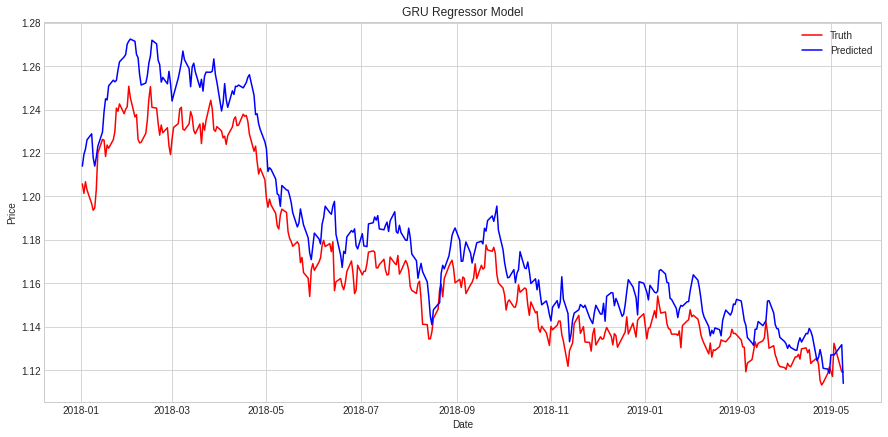

In [62]:
plt.figure(figsize=(15,7))
plt.plot(validation_Y, 'r', label='Truth')
plt.plot(validation_Y.index, predictions_GRU, 'b', label='Predicted')
plt.title("GRU Regressor Model")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

The model with the least mean_absolute_error:
 LIN    0.004009
dtype: float64


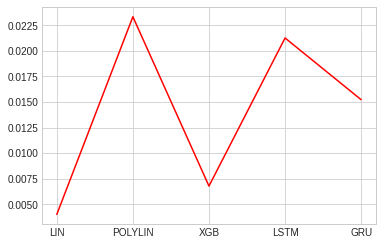

In [63]:
mae_scoring = pd.Series({'LIN':mean_absolute_error(validation_Y, lin_prediction),
                'POLYLIN':mean_absolute_error(validation_Y, Y_poly_predictions),
                'XGB':mean_absolute_error(validation_Y, predictions_xgb),
                'LSTM':mean_absolute_error(validation_Y, predictions_lstm),
                'GRU':mean_absolute_error(validation_Y, predictions_GRU)})

#filtering the regressor with the least mean_absolute_error value
filter = mae_scoring.min()
mae_min = mae_scoring[mae_scoring == mae_scoring.min()]
print('The model with the least mean_absolute_error:\n',mae_min)

plt.plot(mae_scoring, 'r')